# Introduction

In this notebook we will analyze the [Census Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) from UCI Machine Learning Repository.  

The dataset contains three files: 


*   [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) - training set
*   [adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names) - dataset description
*   [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test) - test set 


The data contains anonymous information such as age, occupation, education, working class, etc. The goal is to train a binary classifier to predict the income which has two possible values '>50K' and '<50K'. There are 48842 instances and 14 attributes in the dataset. The data contains a good blend of categorical, numerical and missing values. 

We will use **Logistic Regression** to train our model





# Table of Contents

>[Importing Libraries](#scrollTo=_2oUOp-mixIv)

>[Loading Data](#scrollTo=YVVEtK34i4bV)

>[Exploratory Data Analysis](#scrollTo=nNnaPdClkRvC)

>>[Cleaning the data](#scrollTo=v8xSbpLqkVon)

>>[Handing Numerical Attributes](#scrollTo=uOcQwld3ZR0S)

>>[Handling Categorical Attributes](#scrollTo=Ncrvd9RUtDw2)

>[Creating Pipelines](#scrollTo=cvjQA0Be3Uzh)

>>[ColumnSelector Pipeline](#scrollTo=IWt8funH3bZ6)

>>[Numerical Data Pipeline](#scrollTo=jX_o4-r33sWi)

>>[Categorical Data Pipeline](#scrollTo=3w-s2TdM3ywN)

>>[Feature Union](#scrollTo=mylHVn8V4J8c)

>[Building the Model](#scrollTo=gG9VsQO638lz)

>>[Preparing the data for training](#scrollTo=vgqQ_Ops4N8I)

>>[Training the model](#scrollTo=Wdy7WaYV4TXp)

>>[Testing the model](#scrollTo=g6v5c2pj4Wlh)

>>[Model Evaluation](#scrollTo=9V6q50qi4apQ)

>[Fine Tuning the Model](#scrollTo=nDa6q_oX4faX)

>[Final Remarks](#scrollTo=4GgWdPa54m5X)

>[Exploratory Data Aanalysis](#scrollTo=G03yuo9v6tbp)

>>[Capital Loss](#scrollTo=eERnMy00fI7c)

>>[Hours-per-week](#scrollTo=WfcbzsjPgOQL)



# 1. Importing Libraries

In [19]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Loading Data

*   The train and test dataset doesn't come with the column names by default. Hence we assign the column names manually
*   There are ceratain instances where there are  whitespaces before and after the data values. You can pass a regex to the **sep** paramter to the pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function. We will use the separator as \* , *

*   The missing values in the dataset are indicated by **'?'**. We will use **na_values** parameter to indicate the missing values 
*   The test dataset contains some weird first row, hence we will use **skiprows=1** to skip the first row




In [20]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv('adult.data', names = columns, sep=' *, *', na_values='?')
test_data = pd.read_csv('adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?')

/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Let's look at the first 5 rows of the training data

In [21]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Similarly, we look at the first 5 rows of the test dataset

In [22]:
test_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


Both the train and the test dataset contains the predictor variable '**income**'. This needs to be removed before the data is passed to a machine-learning model

# Exploratory Data Analysis

## Cleaning the data

Let's look for any missing values in both the train and the test dataset. We need to fill/remove these values 

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Observations**

*   There are in total **32561** samples in the train data set
*  There are both categorical and numerical attributes in the dataset
* The columns **workClass**, **occupation**, **native-country** have missing values



In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workClass         15318 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        15315 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16007 non-null object
income            16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


**Observations**

* There are in total 16281  samples in the test data set
* There are both categorical and numerical attributes in the dataset
* There are no missing values

## Handing Numerical Attributes

We will select all the numerical attributes from the dataset using [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) function from the pandas dataframe library 

In [25]:
num_attributes = train_data.select_dtypes(include=['int'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


The variables **age**, **hours-per-week** are self-explanatory. 



*   **fnlwgt**: sampling weight
*  ** education-num**: number of years of education in total
* **capital-gain/capital-loss**: income from investment sources other than salary/wages

fnlwgt is not related to the target variable **income** and will be removed before building the model



**Data Visualizations**
Create hostograms for the numerical atributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c7659e8>,
      dtype=object)

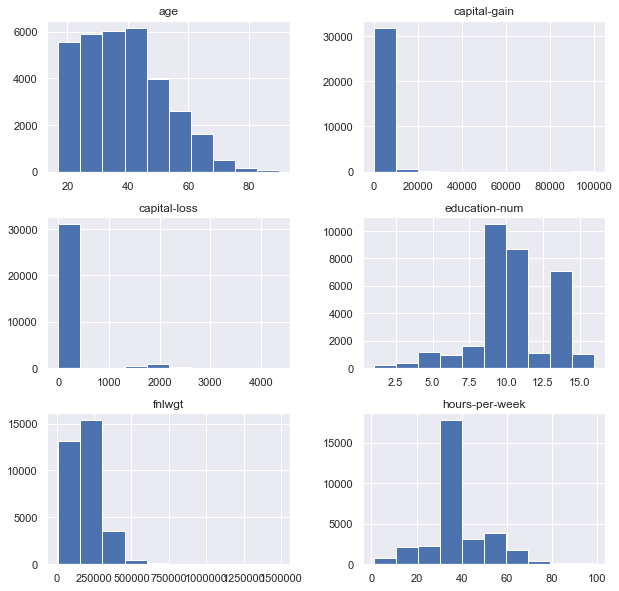

In [26]:
num_attributes.hist(figsize=(10,10))

In [27]:
# describe the numerical features.

num_attributes.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**Observations**

* None of the numerical attributes have missing values 
* The values are on different scales. Many machine learning models require the features to be on the same scale. 
* We can see that there are many outliers present in the data, we will use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sklearn library

## Handling Categorical Attributes


In [28]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


**Data-visualizations**

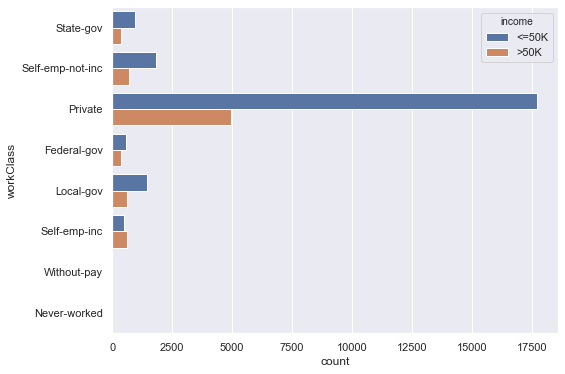

In [29]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(y='workClass', hue='income', data = cat_attributes)

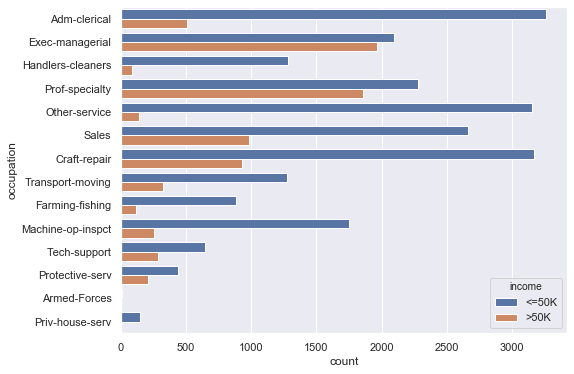

In [30]:
sns.countplot(y='occupation', hue='income', data=cat_attributes)

**Observations**

* All the variables are self-explanatory. 
* The column **education** is just a string representation of the column  **education-num**. We will drop the **education** column 
* The variables **workClass**, **occupation**, **native-country** have missing values. We will replace the missing values in each column with the **most_frequent** occurring value of that column.







We need to handle the numerical and categorical attributes differently.  Numerical attributes needs to be scaled, where as we need to fill the missing values and then encode the categorical values into numerical values.  To apply these sequence of transformations we will use the sklearn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).  We will also build custom transformers that can be directly used with Pipeline

# Creating Pipelines

sklearn has many in-built transformers. However, if the in-built ones doesn't get the job done for you, you can build a custom transformer. All you need to do is to inherit [BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [TransformerMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) classes. You also need to implement the **fit** and **transform** methods. 
* **fit** - should return an instance of self and you can add the logic in 
* **transform** - add the logic here.

## ColumnSelector Pipeline


sklearn doesn't provide libraries to directly manipulate with pandas dataframe. We will write our own Custom Transformer which will select the corresponding attributes (either numerical or categorical)

In [31]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

## Numerical Data Pipeline

For the numerical data, we select the numerical attributes using the **ColumnsSelector** transformer defined above and then scale the values using the Standard Scaler

In [32]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
])

## Categorical Data Pipeline

### Handling missing values

We need to replace the missing values in the categorical columns. We will replace the missing values with the most frequently occuring value in each column.  sklearn comes with [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#) to handle missing values. However,  **Imputer** works only with numerical values. We will write a custom transformer which will accept a list of columns for which you need to replace the missing values and the strategy used to fill the missing values


In [33]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

### Encoding categorical values to numerical 

All the machine learning models expects numerical values. We need to convert the categorical columns to numerical values. We will use [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). This is similar to using [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) except that OneHotEncoder requires numerical columns. 

\\

We need to merge the train and test dataset before using pd.get_dummies as there might be classes in the test dataset that might not be present in the training dataset. But, we need to pass only the encoded train data to further transformers in the pipeline when we train the model. For this in the fit method we will concatenate the train and test dataset and find out all the possible values for a column. In the transform method, when we pass either the train dataset, we will convert each column to [Categorical](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.api.types.CategoricalDtype.html) Type and specify the list of categories that the column can take. pd.get_dummies will create an column of all zeros for the category not present in the list of categories.

\\

The transformer also takes an argument **dropFirst** which indicates whether we should drop the first column after creating dummy columns using pd.get_dummies. By default, the value is set to **True**

In [34]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)
 

We create our pipeline for handling the categorical attributes. First transformer is to select the categorical attributed from the dataframe and then we replace the missing values and then encode the categorical features to numerical features.

### Complete Categorical Pipeline

We select the categorical attributes using the **ColumnsSelector** transformer we defined above. The missing values are replaced by the **CategoricalImputer** pipeline and finally we encode the categorical values to numerical values using the **CategoricalEncoder** transformer. 

In [35]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

## Complete Pipeline

We have two transformer pipeline i.e, **num_pipeline** and **cat_pipeline**. We can merge them using  [FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).

In [36]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

# Building the Model

We now have all the pipelines for preprocessing our data, next step is to prepare the data to be passed to the model. 

In [37]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

## Preparing the data for training

In [38]:
# copy the data before preprocessing
train_copy = train_data.copy()

# convert the income column to 0 or 1 and then drop the column for the feature vectors
train_copy["income"] = train_copy["income"].apply(lambda x:0 if x=='<=50K' else 1)

# creating the feature vector 
X_train = train_copy.drop('income', axis =1)

# target values
Y_train = train_copy['income']

print(X_train.columns)

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')


## Training the model

In [39]:
# set parameter type_df as train for categorical encoder 
# we can set parameter using the name of the transformer while defining the pipeline
# syntax:  name_of_the_transformer__<param_name> = <param_value>

# pass the data through the full_pipeline
X_train_processed = full_pipeline.fit_transform(X_train)
print(X_train_processed.shape)

(32561, 81)


In [43]:
# model = LogisticRegression(random_state=0)
# model = LogisticRegression(random_state=0,solver='lbfgs')
model = LogisticRegression(random_state=0,solver='liblinear')

model.fit(X_train_processed, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
model.coef_

array([[ 0.31298301,  0.77332168,  2.30452917,  0.26044494,  0.392552  ,
        -0.40782299, -0.05792014, -0.17568276,  0.2216556 ,  0.56474542,
        -0.99414493, -0.25271213, -2.11405942, -1.62530814, -1.71343862,
        -1.5146093 , -1.63821229,  0.34046669, -0.1732399 ,  0.4941581 ,
        -0.26339259,  0.01102525, -1.06775792, -0.50091033, -0.34263306,
        -0.89458056, -1.29334389,  0.35681059,  0.24062049, -1.81140397,
        -0.47677993,  0.00815928, -1.17968674, -0.13324801,  1.28104064,
        -0.70967113, -0.17291395, -0.06279269, -0.58771818, -0.45046113,
        -0.83379831, -0.57449345,  0.38921065,  0.26364754, -0.42493459,
         0.11013111, -0.60163122, -0.30269876,  0.24854063,  0.13543639,
        -0.59302442, -0.99174397, -0.09328266,  0.63269315, -1.18609846,
         0.26040733, -0.20931557, -0.11085086, -0.94872672, -1.43215376,
        -0.14837436, -0.1632816 ,  0.04825503, -0.08918625, -0.61843504,
        -0.86424832, -0.53109593, -0.2620243 ,  0.3

# Testing the model

We need to use the same pipeline for preprocessing the test data set before testing the model

In [45]:
# take a copy of the test data set
test_copy = test_data.copy()

# convert the income column to 0 or 1
test_copy["income"] = test_copy["income"].apply(lambda x:0 if x=='<=50K.' else 1)

# separating the feature vecotrs and the target values
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

X_test.columns

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')

In [46]:
# preprocess the test data using the full pipeline
# here we set the type_df param to 'test'
X_test_processed = full_pipeline.fit_transform(X_test)
X_test_processed.shape

(16281, 81)

In [47]:
predicted_classes = model.predict(X_test_processed)
print(predicted_classes)

[0 0 0 ... 1 0 1]


# Model Evaluation

We will use [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from sklearn to find the accuracy of the model 

In [48]:
accuracy_score(predicted_classes, Y_test.values)

0.8524660647380382

Let's plot the [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) 

[[11583  1550]
 [  852  2296]]


Text(48.5, 0.5, 'Actual classes')

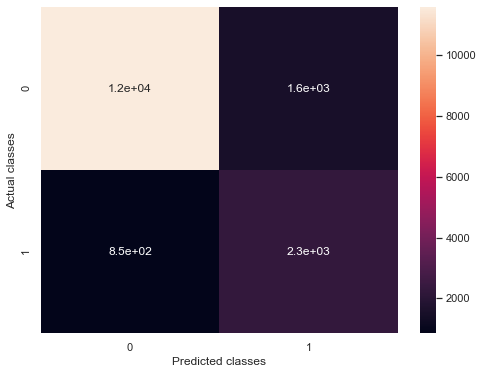

In [49]:
sns.set(rc={'figure.figsize':(8,6)})
cfm = confusion_matrix(predicted_classes, Y_test.values)
sns.heatmap(cfm, annot=True)
print(cfm)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

**Interpretation**

* Y-axis represents the actual classes
* X-axis represents the predicted classes
* **11620** times when the model correctly predicted 0 when the actual class was 0 (**True Negatives**)
* **1587** times the model  predicted 0 when the actual class was 1 (**False Negatives**)
* **815** times the model  predicted 1 when the actual class was 0 (**False Positives**)
* **2259** times the model correctly predicted 1 when the actual class was 1 (**True Positives**) 

# Cross Validation

We will use [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to divide our dataset into k folds. In each iteration, k-1 folds are used as training set and the remaining is used as the training set to validate the model. We use StratifiedKFold because it preserves the percentage of samples of each class. 

\\

If we use [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), we might run the risk of introducing sampling bias i.e, the train set might contain a large  number of samples where income is greater than 50K and the test set contains more samples where income is less than 50K. In this case, the model build from training data will not generalize well for test dataset. Whereas StratifiedKFold will ensure that there are enough samples of each class in both the train and test dataset.

We will use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from the sklearn library to compute scores for each cross-validation. The parameter **cv** determines the cross-validation strategy.

In [50]:
cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train_processed, Y_train, cv=5)
print(scores)
print(np.mean(scores))

/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.84707508 0.84935504 0.85242629 0.85350123 0.8519656 ]
0.8508646475712343


/Users/ddl/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Fine Tuning the Model

By default Logistic Regression takes the below parameters

LogisticRegression(**C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False**)
          
We can fine-tune our model by playing around with the parameters. sklearn comes with [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to do an exhaustive search
over specified parameter values for an estimator.
          

Creating the hyperparameter space

In [58]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
random_state=[0]

# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

Using [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal parameters

In [59]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, cv=5)
best_model = clf.fit(X_train_processed, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


Predicting using the best model parameters

In [60]:
best_predicted_values = best_model.predict(X_test_processed)
print(best_predicted_values)

[0 0 0 ... 1 0 1]


In [61]:
accuracy_score(best_predicted_values, Y_test.values)

0.8524046434494196

[[11583  1551]
 [  852  2295]]


Text(48.5, 0.5, 'Actual classes')

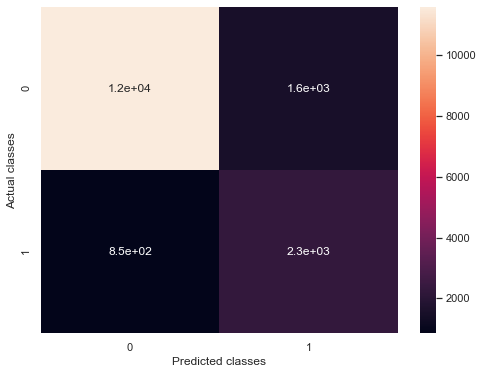

In [62]:
sns.set(rc={'figure.figsize':(8,6)})
cfm = confusion_matrix(best_predicted_values, Y_test.values)
sns.heatmap(cfm, annot=True)
print(cfm)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

# Saving the model to pickle


We have done all the hard work of creating and testing the model. It would be good if we could save the model for future uses rather than retrain it. We will save our model in the [pickle](https://docs.python.org/2/library/pickle.html). 

In [35]:
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

Loading the model from pickle

In [36]:
saved_model = pickle.load(open(filename, 'rb')) 
print(saved_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Now you can predict using the saved model. 